<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [23]:
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from project_functions import collect, compare_precision

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [24]:
df = pd.read_csv('data.csv')
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [25]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 50

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [26]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = number_of_features
DROPOUT_VARIANCE: float = 0.2

In [27]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

In [28]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

In [29]:
st: float = time.time()

batch_size: int = 48
epochs: int = 1

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

42/42 [==============================] - 16s 199ms/step - loss: 1.0166 - accuracy: 0.1801

Time elapsed: 15.94s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [30]:
st: float = time.time()

to_predict = np.array(df.iloc[-window_size:])
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction = scaler.inverse_transform(scaled_prediction).astype(int)[0]

print(*np_prediction, sep=', ')

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

1/1 [==============================] - 3s 3s/step
6, 12, 17, 24, 30, 36

Time elapsed: 3.32s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [31]:
st: float = time.time()

prediction = list(np_prediction)
target: list = collect(len(df) + 2)

precision: float = compare_precision(prediction, target)

print(f'\nTime elapsed: {round(time.time()-st, 3)}s')

Precision = 67%

Prediction:
6 - 12 - 17 - 24 - 30 - 36

Target:
14 - 21 - 26 - 35 - 37 - 40

Time elapsed: 0.509s


In [32]:
with open('storage.csv', 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: list = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('storage.csv', names=column_names)

print(df2.iloc[-6:])

   A   B   C   D   E   F
2  6  12  19  24  30  36
3  6  12  18  23  30  36
4  6  12  18  24  30  36
5  6  12  18  24  30  36
6  5  12  17  24  30  36
7  6  12  17  24  30  36


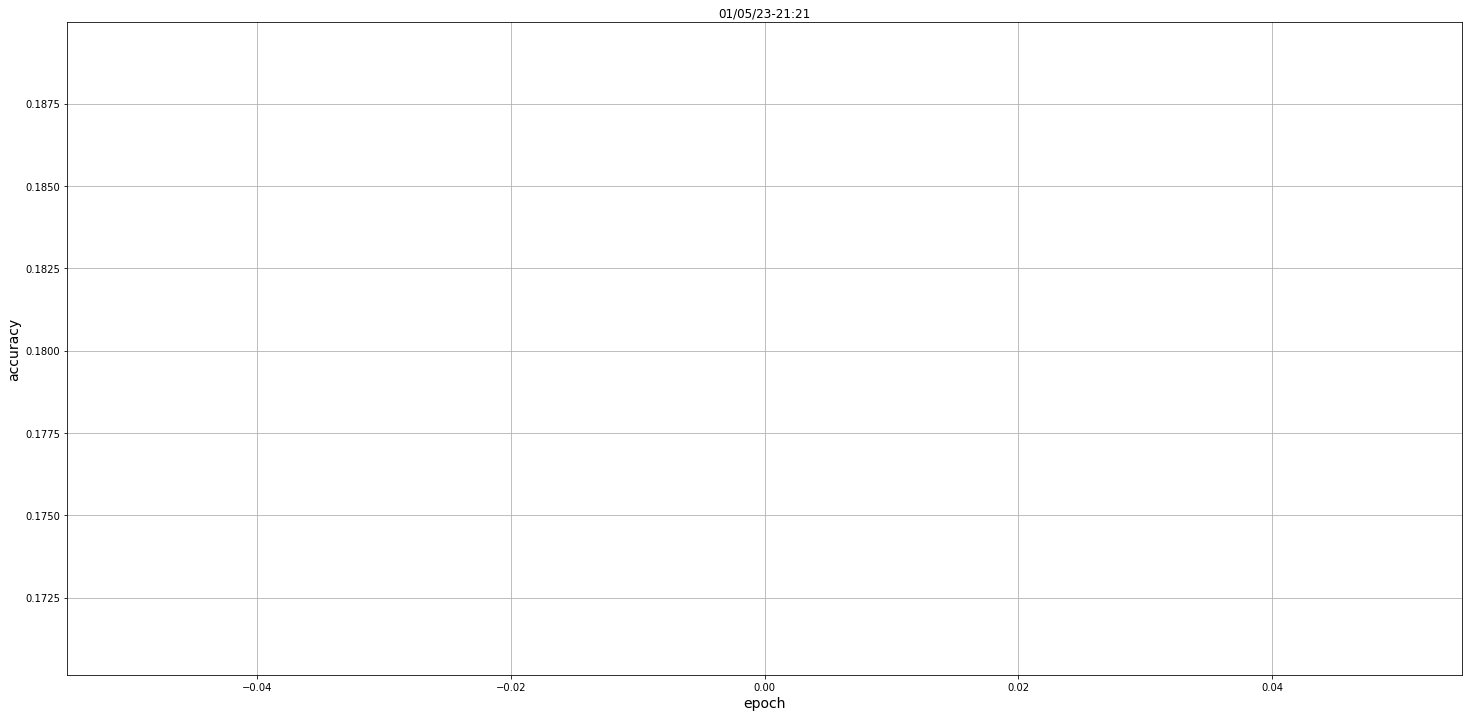

In [33]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(25, 12))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()